## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

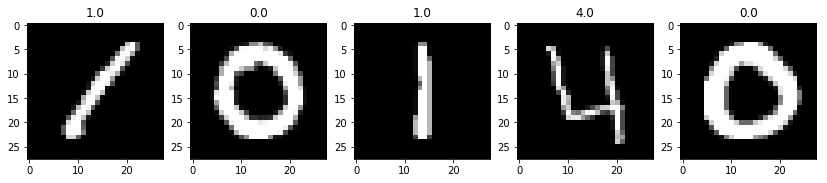

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

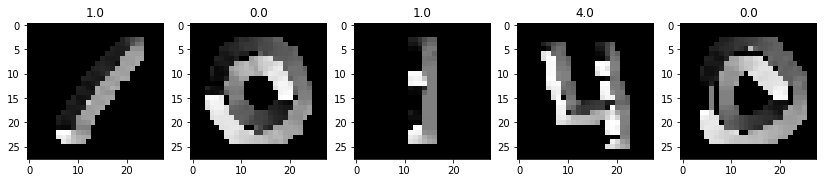

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_theta[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [11]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

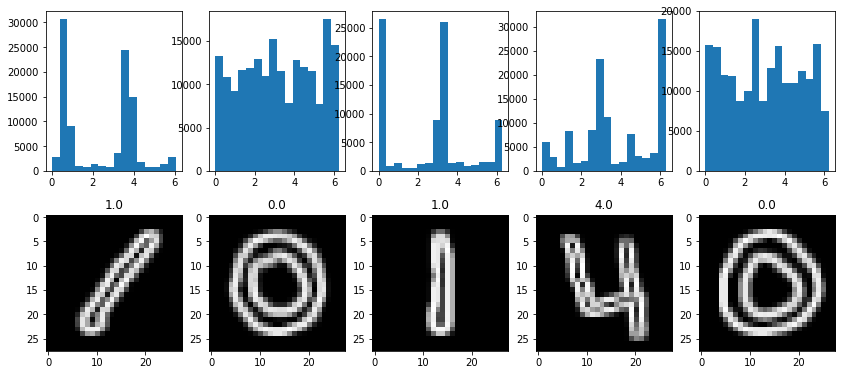

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5,], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i-1].flatten(),
             bins=16, weights=train_g[i-1].flatten())

In [13]:
# изобажение квадратное 28 х 28, задаем кол-во пикселей для разбиения
n = train_img.shape[1]//2
n

14

## Вычисляем гистограммы градиентов

In [14]:
# Гистограммы вычисляются с учетом длины вектора градиента 
bin_n = 16
train_theta_cells = train_theta[:,:n,:n], train_theta[:,n:,:n], train_theta[:,:n,n:], train_theta[:,n:,n:]
train_g_cells = train_g[:,:n,:n], train_g[:,n:,:n], train_g[:,:n,n:], train_g[:,n:,n:]

test_theta_cells = test_theta[:,:n,:n], test_theta[:,n:,:n], test_theta[:,:n,n:], test_theta[:,n:,n:]
test_g_cells = test_g[:,:n,:n], test_g[:,n:,:n], test_g[:,:n,n:], test_g[:,n:,n:]


In [15]:
hists = np.zeros((len(train_g_cells), len(train_img), bin_n))

for j in range(len(train_g_cells)):
    for i in range(len(train_img)):
        hist, border = np.histogram(train_theta_cells[j][i],
                                 bins=bin_n,
                                 range=(0., 2. * np.pi),
                                 weights=train_g_cells[j][i])
        hists[j,i] = hist
train_hist = np.hstack(hists)  
train_hist.shape

(42000, 64)

In [16]:
hists = np.zeros((len(test_g_cells), len(test_img), bin_n))

for j in range(len(test_g_cells)):
    for i in range(len(test_img)):
        hist, border = np.histogram(test_theta_cells[j][i],
                                 bins=bin_n,
                                 range=(0., 2. * np.pi),
                                 weights=test_g_cells[j][i])
        hists[j,i] = hist
test_hist = np.hstack(hists)  
test_hist.shape

(28000, 64)

## Нормируем вектор гистограммы

In [17]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [18]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [19]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [20]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [21]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [22]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [23]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.8266666666666667


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.89      0.91      0.90       816
        1.0       0.89      0.92      0.90       909
        2.0       0.85      0.84      0.85       846
        3.0       0.77      0.83      0.80       937
        4.0       0.88      0.76      0.81       839
        5.0       0.89      0.87      0.88       702
        6.0       0.86      0.89      0.88       785
        7.0       0.86      0.77      0.81       893
        8.0       0.67      0.79      0.73       835
        9.0       0.77      0.69      0.72       838

avg / total       0.83      0.83      0.83      8400



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[744   4  11  10  14   5   5   2  18   3]
 [  0 835   5   0   5   0   3   8  47   6]
 [  7   6 710  64   8   2   9   9  25   6]
 [  9   0  31 782   1  39   4  12  40  19]
 [  4  22  13   3 639   0  67   3  35  53]
 [  2   1   1  50   1 610   7   3  24   3]
 [ 18   9   0   1  14   1 702   0  40   0]
 [  5  31  40  23   3   0   0 686  32  73]
 [ 27  17  18  35  12  27  18   7 661  13]
 [ 20  17   2  49  33   4   4  68  66 575]]


## Предсказания на тестовых данных

In [26]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

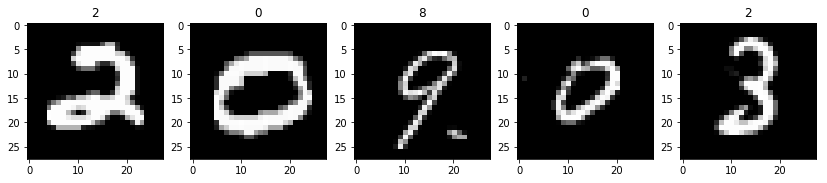

In [27]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [28]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [29]:
# Your submission scored 0.82028